<a href="https://colab.research.google.com/github/Morilla123/Curso/blob/main/Doble_Mnist_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

import numpy as np
from skimage.transform import resize

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
mnist_img_height , mnist_img_width = 28 , 28
(x_train,y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(f"Number of train images:{x_train.shape[0]}")
print(f"Number of test images:{x_test.shape[0]}")

Number of train images:60000
Number of test images:10000


In [4]:
def build_sequence_mnist(data,labels,dataset_size,IS_TRAIN=True):
    
    # sequence data size
    seq_img_height = 64
    seq_img_width = 64
    
    seq_data = np.ndarray(shape=(dataset_size,seq_img_height,seq_img_width),
                           dtype=np.float32)
    seq_labels = [] 
    
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        # num_digits = random.randint(1,2)
        
        s_indices = [random.randint(0,len(data)-1) for p in range(0,2)]

        if IS_TRAIN:
          # concatenating images and labels together
          new_image = np.hstack([x_train[index] for index in s_indices])
          new_label =  [y_train[index] for index in s_indices]
        else:

          new_image = np.hstack([x_test[index] for index in s_indices])
          new_label =  [y_test[index] for index in s_indices]
        
        
        #Resize image
        new_image = resize(new_image,(seq_img_height,seq_img_width))
        
        seq_data[i,:,:] = new_image
        seq_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return seq_data,seq_labels

In [5]:
x_seq_train,y_seq_train = build_sequence_mnist(x_train,y_train,60000)
x_seq_test,y_seq_test = build_sequence_mnist(x_test,y_test,10000,IS_TRAIN=False)

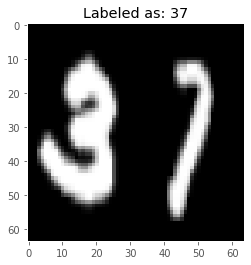

In [6]:
RANDOM_IMG_TO_SHOW = 123
plt.figure()
plt.imshow(x_seq_test[RANDOM_IMG_TO_SHOW], cmap='gray')
plt.title("Labeled as: {}".format(''.join(str(i) for i in y_seq_test[RANDOM_IMG_TO_SHOW])))
plt.grid(b=None)
plt.show()

In [7]:
x_seq_test[RANDOM_IMG_TO_SHOW].shape

(64, 64)

In [8]:
#Converting labels to One-hot representations of shape (set_size,digits,classes)
possible_classes = 10

def convert_labels(labels):
        
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))

    
    for index,label in enumerate(labels):
        
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        
    return [dig0_arr,dig1_arr]

In [9]:
train_labels = convert_labels(y_seq_train)
test_labels = convert_labels(y_seq_test)

In [10]:
np.shape(test_labels[0])

(10000, 10)

In [11]:
import tensorflow as tf
from tensorflow.keras import  applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Lambda, LSTM,Input, TimeDistributed,Activation, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers, Model

nb_classes = 10

img_rows = 64
img_cols = 64
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)


In [12]:
inputs = tf.keras.layers.Input(shape=(None,img_rows,img_cols,img_channels))

In [13]:
cov = TimeDistributed(Conv2D(nb_filters,kernel_size,padding='same'))(inputs)
cov = TimeDistributed(Activation('relu'))(cov)
cov = TimeDistributed(BatchNormalization())(cov)
cov = TimeDistributed(Conv2D(nb_filters,kernel_size))(cov)
cov = TimeDistributed(Activation('relu'))(cov)
cov = TimeDistributed(BatchNormalization())(cov)
cov = TimeDistributed(MaxPooling2D(pool_size=pool_size))(cov)
cov = TimeDistributed(Dropout(0.25))(cov)
cov_out = TimeDistributed(Flatten())(cov)

In [14]:
encoded_vid = LSTM(64,return_sequences=True)(cov_out)
encoded_vid = TimeDistributed(Dense(32, activation='relu'))(encoded_vid)
encoded_vid = Dropout(0.25)(encoded_vid)

In [15]:
c0 = TimeDistributed(Dense(nb_classes, activation='softmax'),name='digit1')(encoded_vid)
c1 = TimeDistributed(Dense(nb_classes, activation='softmax'),name='digit2')(encoded_vid)

In [16]:
model = Model(inputs=[inputs],outputs=[c0,c1], name='custom-cnn-lstm')

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [18]:
model.summary()

Model: "custom-cnn-lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 64, 64  320        ['input_1[0][0]']                
 ted)                           , 32)                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, None, 64, 64  0          ['time_distributed[0][0]']       
 buted)                         , 32)                                               

In [19]:
model.summary()

Model: "custom-cnn-lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 64, 64  320        ['input_1[0][0]']                
 ted)                           , 32)                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, None, 64, 64  0          ['time_distributed[0][0]']       
 buted)                         , 32)                                               

In [20]:
def prep_data_keras(img_data):
    
    ### 10 refers to time_steps
    img_data = img_data.reshape(len(img_data)//10,10,64,64,1)
    img_data = img_data.astype('float32')
    img_data /= 255.0
    
    return img_data

train_images = prep_data_keras(x_seq_train)
test_images = prep_data_keras(x_seq_test)
print(f"Test Image Shape: {test_images.shape}")

Test Image Shape: (1000, 10, 64, 64, 1)


In [21]:
train_labels[0] = train_labels[0].reshape(6000,10,10)
train_labels[1] = train_labels[1].reshape(6000,10,10)

In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import numpy as np

save_dir = 'two-digit-custom-model-test3-with-cnn-lstm.h5'
model_checkpoint = ModelCheckpoint(save_dir, 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')

lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))


In [23]:
early = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [24]:
hist = model.fit(train_images,train_labels,batch_size=32,epochs=50,verbose=2,validation_split=0.2, callbacks=[model_checkpoint, lr_sched, early])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 4.57753, saving model to two-digit-custom-model-test3-with-cnn-lstm.h5
150/150 - 28s - loss: 3.0027 - digit1_loss: 1.5411 - digit2_loss: 1.4616 - digit1_acc: 0.5012 - digit2_acc: 0.5416 - val_loss: 4.5775 - val_digit1_loss: 2.2895 - val_digit2_loss: 2.2881 - val_digit1_acc: 0.1957 - val_digit2_acc: 0.2136 - lr: 1.0000e-04 - 28s/epoch - 185ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 4.57753 to 4.46836, saving model to two-digit-custom-model-test3-with-cnn-lstm.h5
150/150 - 11s - loss: 2.1787 - digit1_loss: 1.1350 - digit2_loss: 1.0436 - digit1_acc: 0.6784 - digit2_acc: 0.7082 - val_loss: 4.4684 - val_digit1_loss: 2.2380 - val_digit2_loss: 2.2304 - val_digit1_acc: 0.3292 - val_digit2_acc: 0.2278 - lr: 1.0000e-04 - 11s/epoch - 72ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 4.46836 to 4.03928, saving model to two-digit-custom-model-test3-with-cnn-lstm.h5
150/150 - 11s - loss: 1.8262 - digit1_loss: 0.9556 - digit2

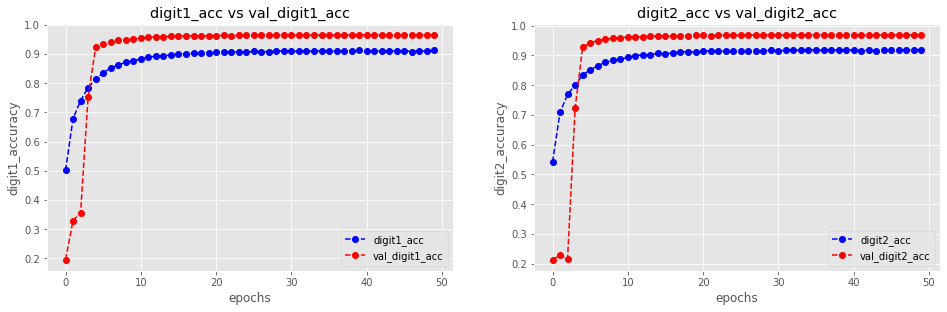

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(16,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(hist.history['digit1_acc'],'bo--', label = "digit1_acc")
    plt.plot(hist.history['val_digit1_acc'], 'ro--', label = "val_digit1_acc")
    plt.title("digito 1 acc t1_acc vs val digito 1")
    plt.ylabel("digit1_accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(hist.history['digit2_acc'],'bo--', label = "digit2_acc")
    plt.plot(hist.history['val_digit2_acc'], 'ro--', label = "val_digit2_acc")
    plt.title("digit2_acc vs val_digit2_acc")
    plt.ylabel("digit2_accuracy")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
  
plot_accuracy_loss(hist)

In [26]:
model.save("multi_mnist.h5")

In [27]:
model.load_weights('/content/two-digit-custom-model-test3-with-cnn-lstm.h5')

In [43]:
test_labels[0] = test_labels[0].reshape(1000,10,10)
test_labels[1] = test_labels[1].reshape(1000,10,10)

In [44]:
scores = model.evaluate(test_images, test_labels)
print(f"Primer digito: {scores[3]} , Segundo digito: {scores[4]}")

32/32 [==============================] - 1s 33ms/step - loss: 0.3614 - digit1_loss: 0.1899 - digit2_loss: 0.1715 - digit1_acc: 0.9668 - digit2_acc: 0.9689
Primer digito: 0.9667999744415283 , Segundo digito: 0.9689000248908997


In [30]:
#Printing some examples of real and predicted labels
predictions = model.predict(test_images)
predictions[0] = predictions[0].reshape(10000,10)
predictions[1] = predictions[1].reshape(10000,10)
test_labels[0] = test_labels[0].reshape(10000,10)
test_labels[1] = test_labels[1].reshape(10000,10)

test_images.shape

for i in random.sample(range(0,10000),2):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,2):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [8, 1]
Predicted labels: [8, 1]

Actual labels: [8, 5]
Predicted labels: [8, 5]



In [33]:
%%capture
!pip install opencv-python-headless=='4.1.2.30'
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

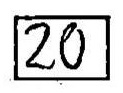

(93, 123, 3)

In [65]:
img = cv2.imread("/content/20.jpg")
cv2_imshow(img)
img.shape

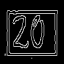

(1, 1, 64, 64, 1)

In [66]:
img = cv2.Canny(img, 250, 250)
# cv2_imshow(img)
img.shape
dim = (64,64)
img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
cv2_imshow(img)
img.shape
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=1)
img = np.expand_dims(img, axis=-1)
img.shape

In [67]:
predictions = model.predict(img)
predictions[0] = np.argmax(predictions[0])
predictions[1] = np.argmax(predictions[1])
print(predictions[0],predictions[1])

2 8


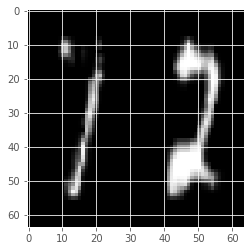

In [135]:
plt.figure()
plt.imshow(x_seq_test[0], cmap='gray')
plt.show()

In [144]:
predictions = model.predict(test_images[0].reshape(10000,10))

ValueError: ignored

In [ ]:

#defining the input
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, kernel_size, activation='relu',kernel_size,padding='same', input_shape=(None,img_rows,img_cols,img_channels)),
    tf.keras.layers.MaxPooling2D(pool_size),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(64,return_sequences=True)

    tf.keras.layers.Dense(256, activation='relu')
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense((nb_classes, activation='softmax'),name='digit1')
    tf.keras.layers.Dense((nb_classes, activation='softmax'),name='digit2')
